In [1]:
suppressPackageStartupMessages({
    library(SummarizedExperiment)
    library(DESeq2)
    library(tidyverse)
    library(data.table)
    library(EnhancedVolcano)
    })


dir.create('../_m', showWarnings = TRUE, recursive = TRUE)
setwd('../_m')

Warning message in dir.create("../_m", showWarnings = TRUE, recursive = TRUE):
“'../_m' already exists”


In [2]:
rdata_files <- Sys.glob('../../../speaqeasy_star/_m/count_objects/*.Rdata')
rdata_files

load(rdata_files[1]) #exons
#load(rdata_files[2]) #genes
#load(rdata_files[3]) # junctions
#load(rdata_files[4]) # transcripts 


[1] "../../../speaqeasy_star/_m/count_objects/rse_exon_Jlab_experiment_n53.Rdata"
[2] "../../../speaqeasy_star/_m/count_objects/rse_gene_Jlab_experiment_n53.Rdata"
[3] "../../../speaqeasy_star/_m/count_objects/rse_jx_Jlab_experiment_n53.Rdata"  
[4] "../../../speaqeasy_star/_m/count_objects/rse_tx_Jlab_experiment_n53.Rdata"

In [3]:
rm(rdata_files)
rse_obj <- ls()
rse_obj
#ls()

[1] "rse_exon"

In [4]:
# new DE model: control+deltasva VS XDP

In [5]:
metadata = fread('../../metadata/_m/XDP_striatal_organoids_metadata.tsv') %>%
                filter(RIN >= 6) %>%
                dplyr::select(1:11) %>%
                #mutate(new_Cell_line = ifelse(Cell_line == 'Control' | Cell_line == 'DELTA-SVA-XDP', 'Control','XDP')) %>%
                #convert these categorical variables (columns) to factor
                mutate_at(vars(Differentiation_cohort, iPSC_line, Cell_line, Sex, Day_of_Maturation, Kit, Disease_Status, individual), factor)

head(metadata)
table(metadata$Cell_line)


Differentiation_cohort,Sample,iPSC_line,Cell_line,Sex,Day_of_Maturation,RIN,Kit,Disease_Status,individual,SAMPLE_ID
<fct>,<chr>,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<fct>,<chr>
A,1N,33113.2I,Control,Male,30,8.7,Zymo_R2062,healthy,33113,1N
A,2N,33109.2G,XDP,Male,30,8.0,Zymo_R2062,patient,33109,2N
A,3N,33109.2G-1A4,DELTA-SVA-XDP,Male,30,9.0,Zymo_R2062,healthy,33109,3N
A,4N,33109.2G-2F2,DELTA-SVA-XDP,Male,30,8.8,Zymo_R2062,healthy,33109,4N
A,5N,33113.2I,Control,Male,60,7.6,Zymo_R2062,healthy,33113,5N
A,6N,33109.2G,XDP,Male,60,7.6,Zymo_R2062,patient,33109,6N



Carrier-Control  Carrier-Mutant         Control   DELTA-SVA-XDP             XDP 
              2               7              12              15              11 

In [6]:
merge_with_metadata = function(rse, metadata_df)
{
    # Return a new_rse object such that:
    #  (1) new_rse contains only the samples present in both rse and metadata_df
    #  (2) colData(new_rse) contains information from both colData(rse) and metadata_df 
    
    x = as_tibble(colData(rse))
    y = as_tibble(metadata_df)
    
    new_coldata = x  %>% 
                    inner_join(y, by=c("SAMPLE_ID" = "Sample"))
    
    new_rse = rse[, new_coldata$SAMPLE_ID]
    
    stopifnot(dim(new_coldata)[1] == dim(new_rse)[2])
    stopifnot(all(colnames(new_rse) == new_coldata$SAMPLE_ID))
    
    colData(new_rse) = DataFrame(new_coldata)
    colnames(new_rse) = new_coldata$SAMPLE_ID
    return(new_rse)
}

In [7]:
# we will use only exons from the genes
# surviving 
# selected by the gene differential expression analysis
load("gene_dds.Rdata")
genedds = dds
rm(dds)
genedds

class: DESeqDataSet 
dim: 28228 22 
metadata(1): version
assays(4): counts mu H cooks
rownames(28228): ENSG00000238009.6 ENSG00000241860.7 ...
  ENSG00000275405.1 ENSG00000275869.1
rowData names(56): Length gencodeID ... deviance maxCooks
colnames(22): 12N 13N ... 53R 9
colData names(72): SAMPLE_ID basic_statistics ... SAMPLE_ID.y
  sizeFactor

In [8]:
# checking how many genes to be kept
genes_to_keep = rownames(genedds)
genes_to_keep %>% length()
genes_to_keep %>% head()
is.na(genes_to_keep) %>% sum()

[1] 28228

[1] "ENSG00000238009.6"  "ENSG00000241860.7"  "ENSG00000279457.4" 
[4] "ENSG00000228463.10" "ENSG00000290385.1"  "ENSG00000230021.10"

[1] 0

In [9]:
# checking how many of those
# are included in the exon object
rowData(rse_exon) %>%
    as_tibble() %>%
    dplyr::filter(gene_id %in% genes_to_keep) %>%
    pull(gene_id) %>%
    unique() %>%
    length()

[1] 28227

In [10]:
rowData(rse_exon) %>% head(100) %>% as_tibble()

Length,gencodeID,ensemblID,gene_type,Symbol,EntrezID,gene_id,exon_gencodeID,exon_libdID,meanExprs,Class,coord,NumTx,gencodeTx
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<int>,<chr>
359,ENSG00000290825.1,ENSG00000290825,lncRNA,DDX11L2,84771,ENSG00000290825.1,ENSE00002234944.1,e1,0.001151334,InGen,chr1:11869-12227(+),1,ENST00000456328.2
109,ENSG00000290825.1,ENSG00000290825,lncRNA,DDX11L2,84771,ENSG00000290825.1,ENSE00003582793.1,e2,0.000000000,InGen,chr1:12613-12721(+),1,ENST00000456328.2
1189,ENSG00000290825.1,ENSG00000290825,lncRNA,DDX11L2,84771,ENSG00000290825.1,ENSE00002312635.1,e3,0.000000000,InGen,chr1:13221-14409(+),1,ENST00000456328.2
48,ENSG00000223972.6,ENSG00000223972,transcribed_unprocessed_pseudogene,DDX11L1,100287102,ENSG00000223972.6,ENSE00001948541.1,e4,0.000000000,InGen,chr1:12010-12057(+),1,ENST00000450305.2
49,ENSG00000223972.6,ENSG00000223972,transcribed_unprocessed_pseudogene,DDX11L1,100287102,ENSG00000223972.6,ENSE00001671638.2,e5,0.004217643,InGen,chr1:12179-12227(+),1,ENST00000450305.2
85,ENSG00000223972.6,ENSG00000223972,transcribed_unprocessed_pseudogene,DDX11L1,100287102,ENSG00000223972.6,ENSE00001758273.2,e6,0.000000000,InGen,chr1:12613-12697(+),1,ENST00000450305.2
78,ENSG00000223972.6,ENSG00000223972,transcribed_unprocessed_pseudogene,DDX11L1,100287102,ENSG00000223972.6,ENSE00001799933.2,e7,0.000000000,InGen,chr1:12975-13052(+),1,ENST00000450305.2
154,ENSG00000223972.6,ENSG00000223972,transcribed_unprocessed_pseudogene,DDX11L1,100287102,ENSG00000223972.6,ENSE00001746346.2,e8,0.000000000,InGen,chr1:13221-13374(+),1,ENST00000450305.2
218,ENSG00000223972.6,ENSG00000223972,transcribed_unprocessed_pseudogene,DDX11L1,100287102,ENSG00000223972.6,ENSE00001863096.1,e9,0.000000000,InGen,chr1:13453-13670(+),1,ENST00000450305.2


In [11]:
deseq2_analysis = function(rse, rse_type, sample_ids, design, analysis_name, to_keep)
{
    # Parameters:
    #  rse: RangedSummarizedExperiment
    #  sample_ids: a list of sample ids (subset of colData(rse))
    #  design: linear model formula for DE analysis. Covariates are in colData(rse)
    #  analysis_name: name of analysis. This is also a folder under _m where to save the analysis results
    #
    # Do a DESeq2 analysis on rse object <rse>, considering only <sample_ids>, and applying model <design>
    
    
    # The last variable in the design formula is the one that DESeq2 calculates DE with. We save its name in de_variable 
    # so we can use it later.
    stopifnot(is_formula(design))
    de_variable = all.vars(design) %>% tail(n=1)
    
    # Subset rse to samples of interest
    rse_subset = rse[, sample_ids]
    
    # See if type of counts is double or integer
    stopifnot(type(assays(rse)[['counts']]) %in% c('double', 'integer'))
    
    # If type of counts is double, round and convert to integer
    # This happens with kallisto transcript quantification, which has non-integer counts.
    # When quantifying transcripts with kallisto, it is OK to round the counts. 
    # When quantifying genes with kallisto (combining multiple transcripts from the same gene), one needs to load the quantifications with tximport,
    # which takes into account average transcript length. (It is not the case here with speaqeasy output).
    #if(type(assays(rse)[['counts']]) == 'double')
    #{
    #    assays(rse)[['counts']] = round(assays(rse)[['counts']])
    #    type(assays(rse)[['counts']]) = 'integer'
    #}
    
    ##TEST only with 5000 features
    #dds <- DESeqDataSet(rse_subset, design = design)
    #rse_subset <- rse_subset[1:3000,]
    
    # ifelse(length(rse_subset@assays) > 1, 
    #            assays(rse_subset)$tpm <- NULL,
    #            'ok!')
  
    #assays(rse_subset)$tpm <- NULL
   
    #create a deseq2 obj
    dds <- DESeqDataSet(rse_subset, design = design)
    
    # Removed lowly expressed genes
    # this will rely on the analysis previously done for genes
    # in ./../deseq2_multiplemodels_genes_no_lfcShrink_filter_low/_m/Mature_organoids_all_comparison_design1_deseq2/gene_dds.Rdata
    dds <- dds[rowData(dds)$gene_id %in% to_keep,]

    # filtering by rowSums to enable calculations
    # and remove extreme low counts
    keep <- rowSums(counts(dds)) >= 2
    dds <- dds[keep,]
    
    # Calculate DE
    dds <- estimateSizeFactors(dds)
    dds <- DESeq(dds)

    # Get results
    #res <- results(dds)
    res <- results(dds, name=paste0(resultsNames(dds)[length(resultsNames(dds))]))
    # or to shrink log fold changes association with condition:    
#    res <- lfcShrink(dds, coef=paste0(resultsNames(dds)[length(resultsNames(dds))]),type='apeglm')

    #Print results
    results(dds, alpha=0.05, lfcThreshold=0) %>% 
                                            summary() # fdr < 0.05 & no FC
    results(dds, alpha=0.1, lfcThreshold=0) %>% 
                                            summary() # fdr < 0.1 & no FC
    ####################
    print('raw pval')
    results(dds, alpha=0.05, lfcThreshold=0, 
            pAdjustMethod = 'none') %>% 
                                    summary()# raw p-value < 0.05 & no FC
    
    
    
    # get gene annotation from rse
    annotated_genes = rowData(dds) %>% 
                                    as.data.frame %>% 
                                    rownames_to_column(var = "ROW_INDEX") #%>% 
                #                    as_tibble()
    
    # Order results by pvalue and merge with gene annotation
    annotated_results = res[order(res$pvalue),] %>% 
                                                as.data.frame %>% 
                                                rownames_to_column(var = "ROW_INDEX") %>% #as_tibble() %>% 
                                                left_join(annotated_genes, by="ROW_INDEX")

    
    #mkdir -p analysis name
    dir.create(analysis_name, showWarnings = TRUE, recursive = TRUE)

    #save de results here
    save(dds, file=paste0(analysis_name, '/', rse_type,'_dds.Rdata'))
    fwrite(annotated_results, file=paste0(analysis_name, '/', rse_type,'_deseq2_results.tsv'),sep='\t')
    #create a empty file with the design of the deseq2 linear model
    file.create(paste0(analysis_name, '/~',sample_select$design[1]))

    
    
        
    top_gene = annotated_results[1,]$ROW_INDEX
    top_genesymbol = annotated_results[1,]$Symbol
    top_logfc = format(annotated_results[1,]$log2FoldChange, nsmall = 2)
    
        
    
    # plot top gene boxplot so we know the direction of fold change
    p1 = plotCounts(dds, gene=top_gene, intgroup=de_variable, returnData=TRUE) %>%
               #as_tibble() %>% 
               ggplot(aes(y=.data[['count']], x=.data[[de_variable]])) + 
               geom_boxplot(fill="darkgray") + 
               geom_jitter() + 
               scale_y_log10() + 
               ylab('log10(Normalized Counts)') + 
               ggtitle(paste0(top_gene,'\n', top_genesymbol, '\nlog2FC= ',top_logfc)) +
               theme_classic()

    ggsave(paste0(analysis_name,'/',rse_type,'_top_DE_feature_boxplot.pdf'), p1)
    
    plot(p1)
    
    p2 = EnhancedVolcano(annotated_results,
                lab = annotated_results$Symbol,
                x = 'log2FoldChange',
                y = 'padj',
                pCutoff = 0.05,
                FCcutoff = 0.0,
                title = analysis_name
               ) 
    
    ggsave(paste0(analysis_name,'/',rse_type,'_enhancedvolcano_fdr005.pdf'), p2)
    
    plot(p2)

    return(annotated_results)
}
    
    

In [12]:
# Load deseq2 samples per each deseq2 model/design

deseq2_version <- fread('../../metadata/de_models/_m/deseq2_models_description.tsv') #%>% filter(version != 'v24')

design_version <- deseq2_version$design

analysis_version <- deseq2_version$model

deseq2_model <- fread('../../metadata/de_models/_m/de_comparisons.tsv') #%>% filter(deseq2 != 'Mature_organoids_male__DELTASVA_comparison_deseq2')



#deseq2_model %>% head()

In [13]:
analysis_version = analysis_version[str_detect(analysis_version, "Mature_organoids_all_comparison_design1_deseq2") |
                                    str_detect(analysis_version, "^Day")]

In [14]:
#analysis_version == unique(deseq2_model$deseq2)

[1] "exon - Mature_organoids_all_comparison_design1_deseq2"


  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.



factor levels were dropped which had no samples



using pre-existing size factors



estimating dispersions



gene-wise dispersion estimates



mean-dispersion relationship



final dispersion estimates



fitting model and testing



970 rows did not converge in beta, labelled in mcols(object)$betaConv. Use larger maxit argument with nbinomWaldTest




out of 518329 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 79, 0.015%
LFC < 0 (down)     : 93, 0.018%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 518329 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 84, 0.016%
LFC < 0 (down)     : 99, 0.019%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "raw pval"

out of 518329 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 5376, 1%
LFC < 0 (down)     : 6104, 1.2%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Saving 7 x 7 in image


Saving 7 x 7 in image


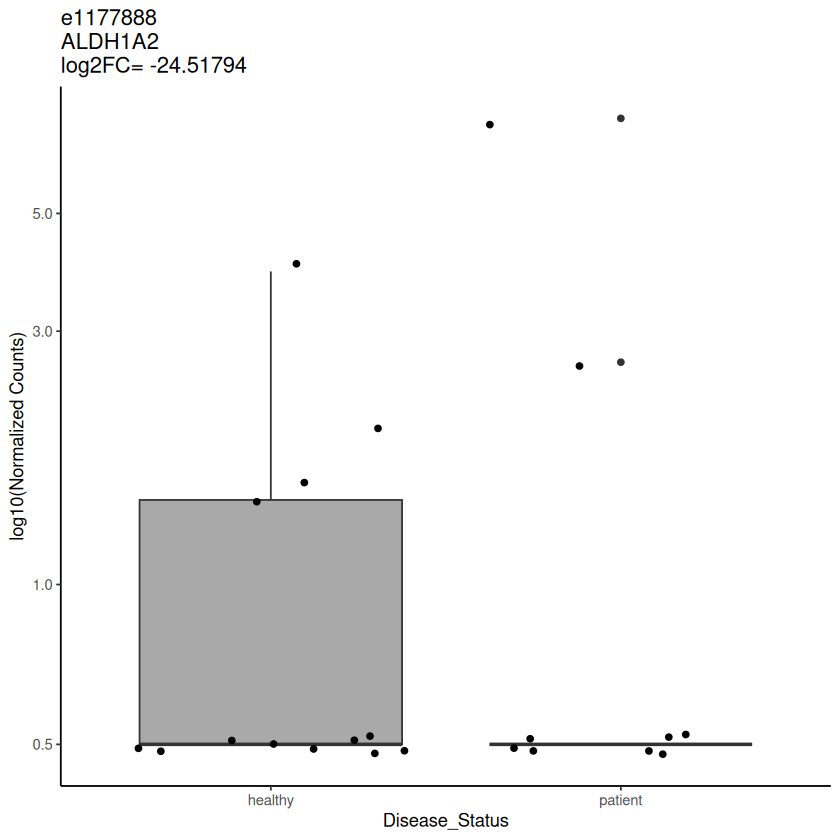

[1] "exon - Day30_All_Male_Pairwise_controlxdp_deseq2"


factor levels were dropped which had no samples



using pre-existing size factors



estimating dispersions



gene-wise dispersion estimates



mean-dispersion relationship



final dispersion estimates



fitting model and testing




out of 462356 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 4, 0.00087%
LFC < 0 (down)     : 15, 0.0032%
outliers [1]       : 0, 0%
low counts [2]     : 44699, 9.7%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 462356 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 6, 0.0013%
LFC < 0 (down)     : 18, 0.0039%
outliers [1]       : 0, 0%
low counts [2]     : 161353, 35%
(mean count < 4)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "raw pval"

out of 462356 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 478, 0.1%
LFC < 0 (down)     : 634, 0.14%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Saving 7 x 7 in image


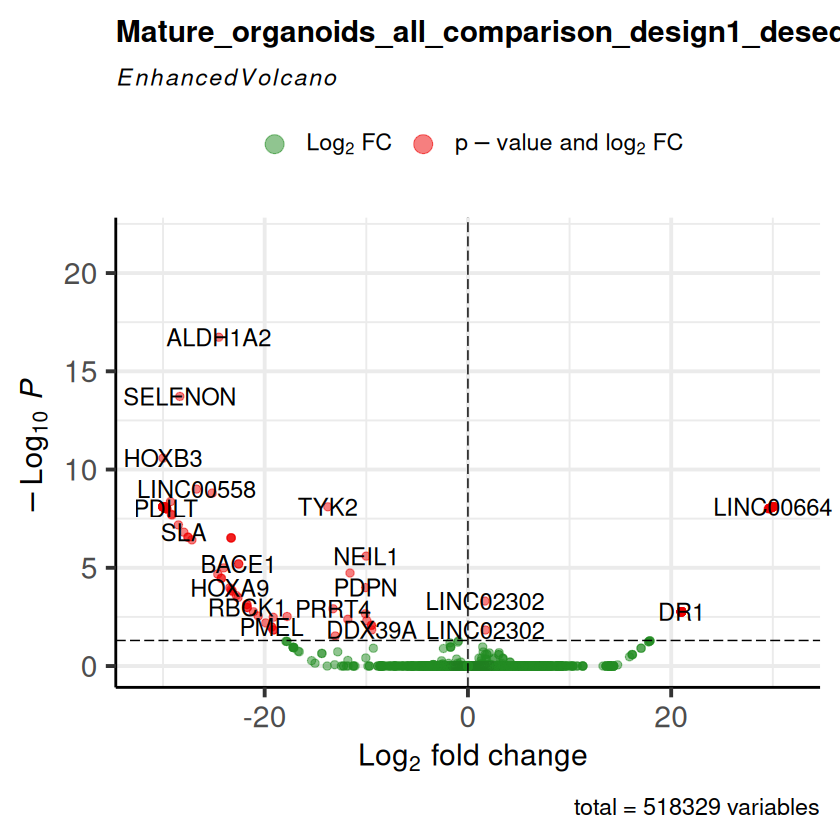

Saving 7 x 7 in image


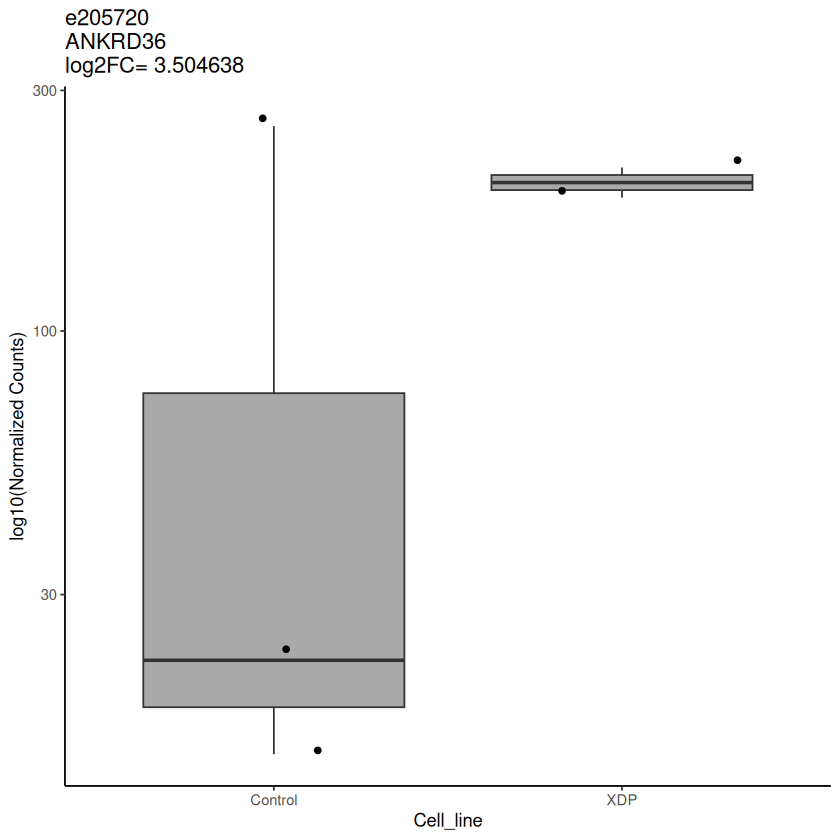

[1] "exon - Day30_All_Male_Pairwise_controldelta_deseq2"


factor levels were dropped which had no samples



  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



using pre-existing size factors



estimating dispersions



gene-wise dispersion estimates



mean-dispersion relationship



  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



final dispersion estimates



fitting model and testing




out of 485382 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 54, 0.011%
LFC < 0 (down)     : 132, 0.027%
outliers [1]       : 0, 0%
low counts [2]     : 47047, 9.7%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 485382 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 97, 0.02%
LFC < 0 (down)     : 147, 0.03%
outliers [1]       : 0, 0%
low counts [2]     : 9170, 1.9%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "raw pval"

out of 485382 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 7928, 1.6%
LFC < 0 (down)     : 4884, 1%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Saving 7 x 7 in image


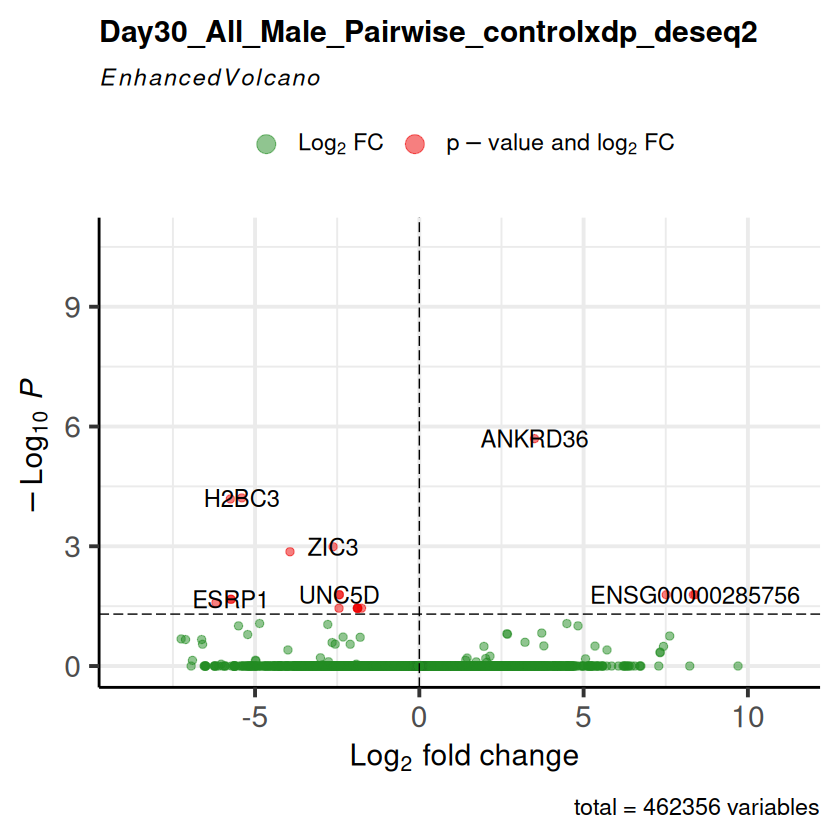

Saving 7 x 7 in image


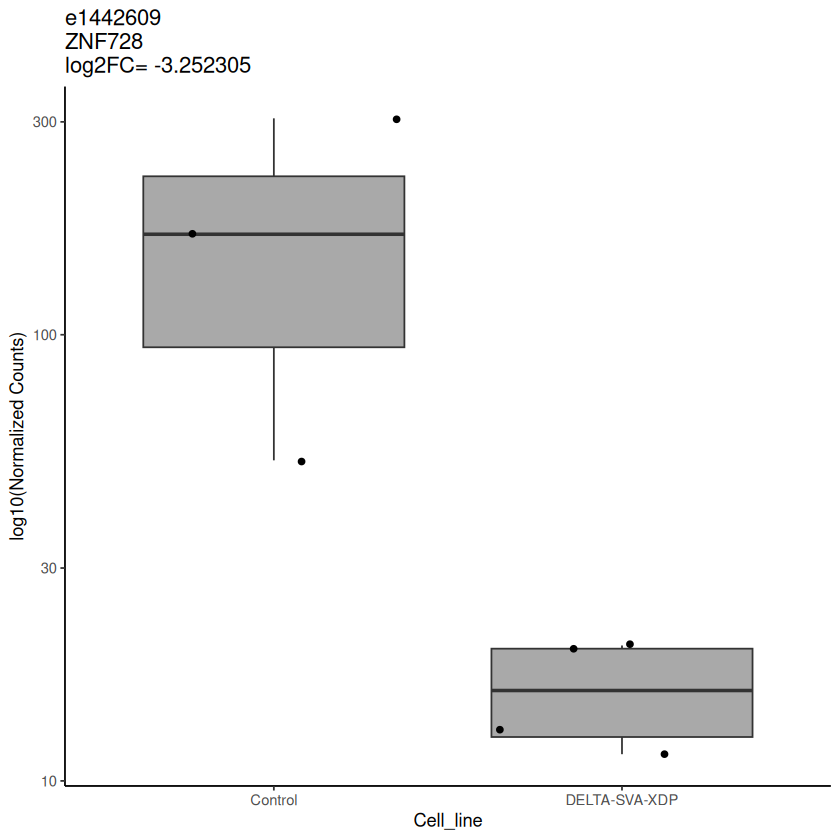

[1] "exon - Day30_All_Male_Pairwise_deltaxdp_deseq2"


factor levels were dropped which had no samples



  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



using pre-existing size factors



estimating dispersions



gene-wise dispersion estimates



mean-dispersion relationship



  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



final dispersion estimates



fitting model and testing




out of 478486 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 228, 0.048%
LFC < 0 (down)     : 556, 0.12%
outliers [1]       : 0, 0%
low counts [2]     : 259749, 54%
(mean count < 15)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 478486 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 461, 0.096%
LFC < 0 (down)     : 939, 0.2%
outliers [1]       : 0, 0%
low counts [2]     : 250473, 52%
(mean count < 13)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "raw pval"

out of 478486 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 7407, 1.5%
LFC < 0 (down)     : 12389, 2.6%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Saving 7 x 7 in image


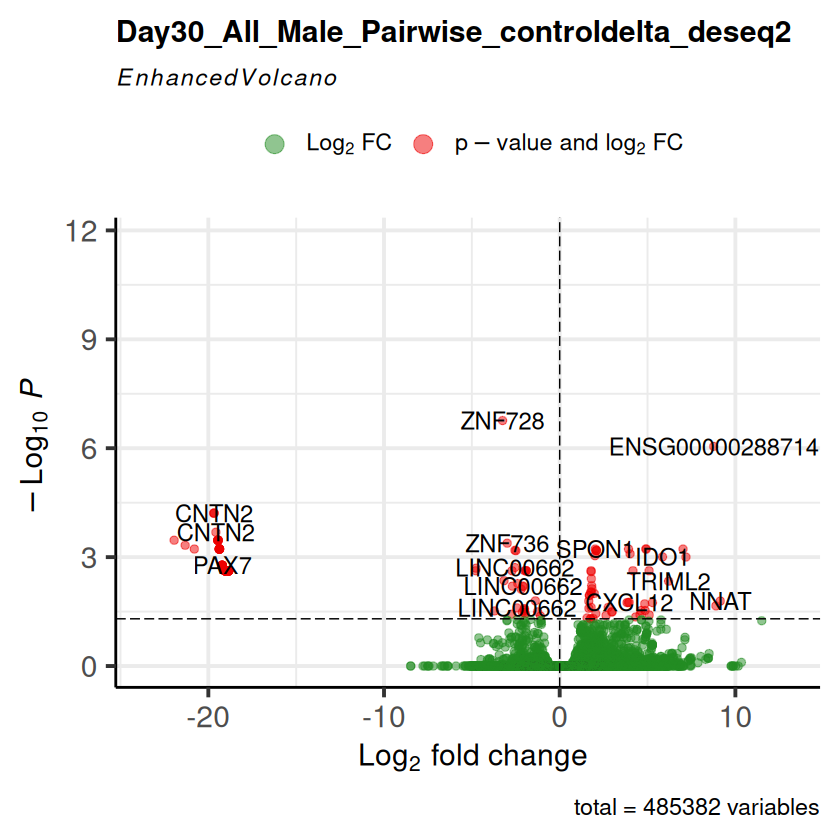

Saving 7 x 7 in image


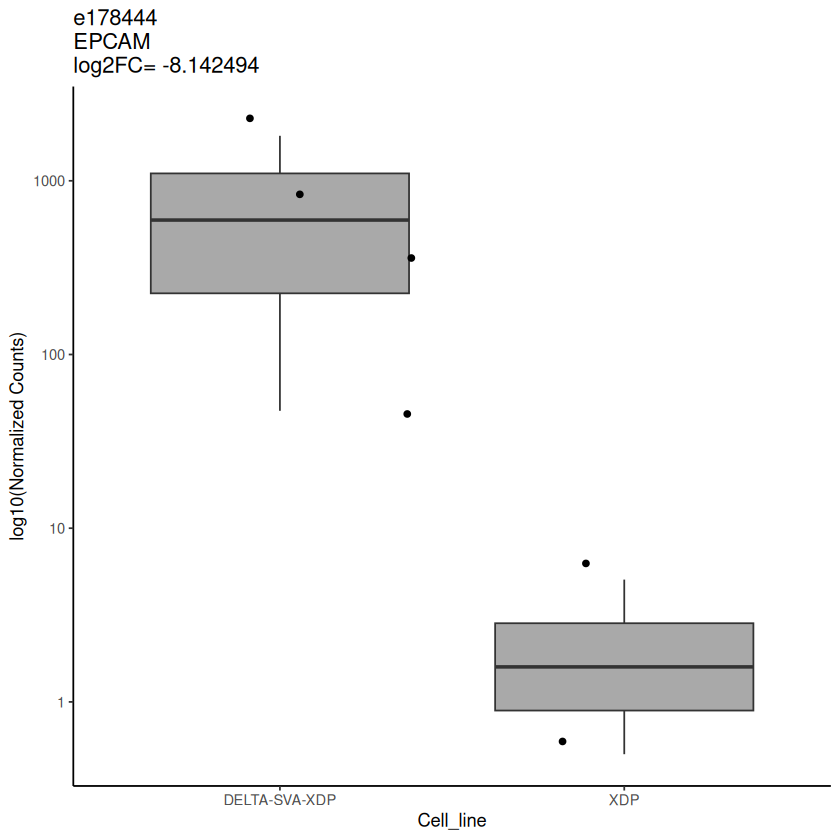

[1] "exon - Day60_All_Male_Pairwise_controlxdp_deseq2"


factor levels were dropped which had no samples



using pre-existing size factors



estimating dispersions



gene-wise dispersion estimates



mean-dispersion relationship



final dispersion estimates



fitting model and testing




out of 478259 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 57, 0.012%
LFC < 0 (down)     : 102, 0.021%
outliers [1]       : 0, 0%
low counts [2]     : 315259, 66%
(mean count < 25)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 478259 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 87, 0.018%
LFC < 0 (down)     : 188, 0.039%
outliers [1]       : 0, 0%
low counts [2]     : 315259, 66%
(mean count < 25)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "raw pval"

out of 478259 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 2958, 0.62%
LFC < 0 (down)     : 4755, 0.99%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Saving 7 x 7 in image


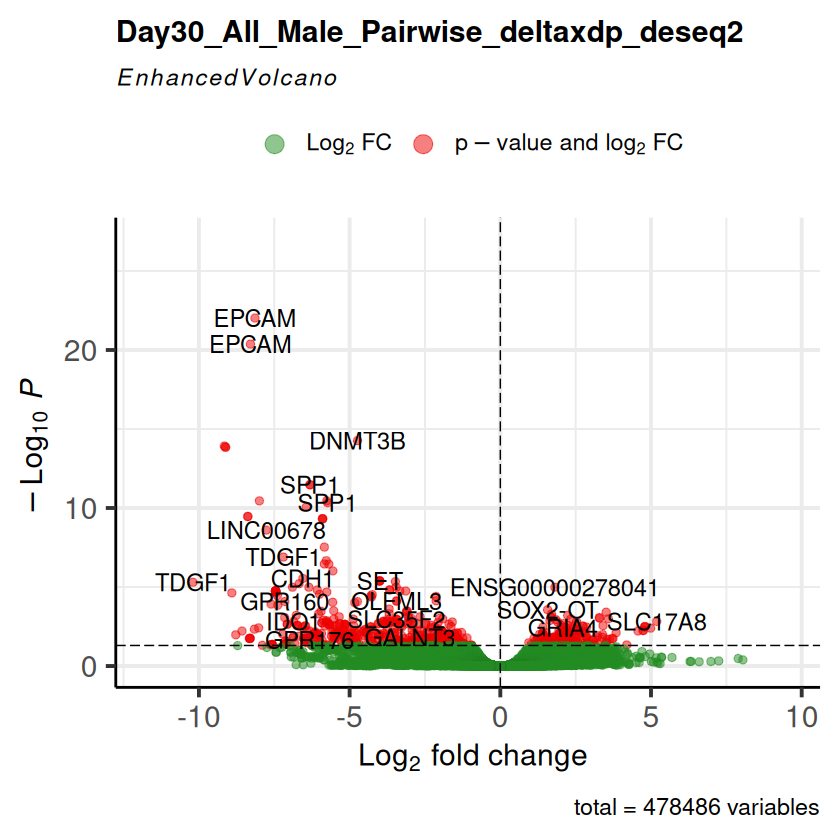

Saving 7 x 7 in image


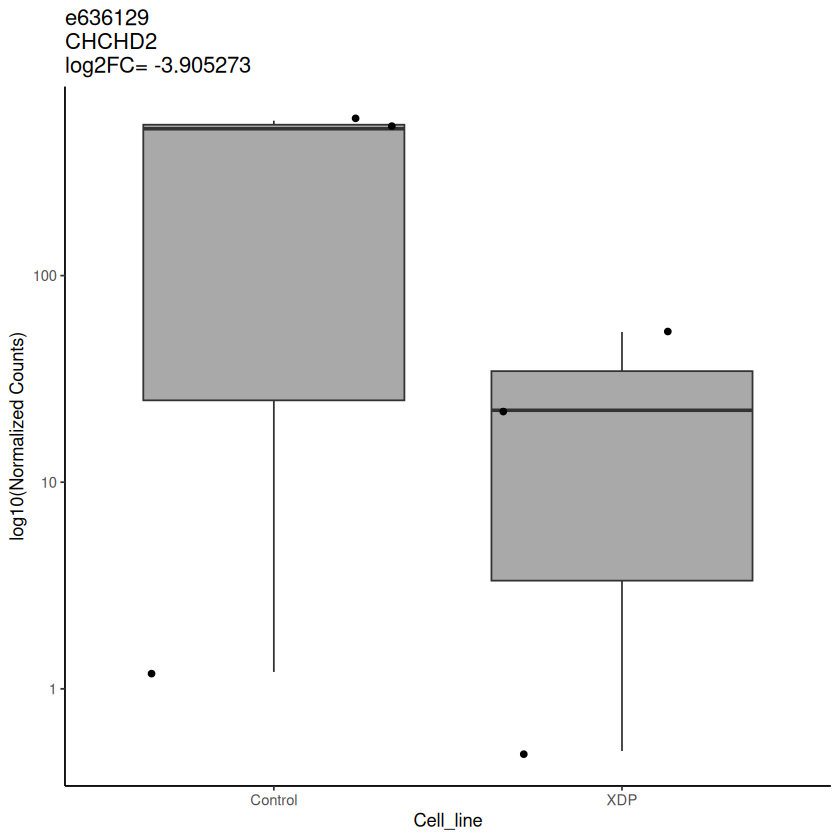

[1] "exon - Day60_All_Male_Pairwise_controldelta_deseq2"


factor levels were dropped which had no samples



  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



using pre-existing size factors



estimating dispersions



gene-wise dispersion estimates



mean-dispersion relationship



  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



final dispersion estimates



fitting model and testing




out of 491922 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 1144, 0.23%
LFC < 0 (down)     : 1464, 0.3%
outliers [1]       : 0, 0%
low counts [2]     : 314730, 64%
(mean count < 19)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 491922 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 2024, 0.41%
LFC < 0 (down)     : 2403, 0.49%
outliers [1]       : 0, 0%
low counts [2]     : 314730, 64%
(mean count < 19)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "raw pval"

out of 491922 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 15838, 3.2%
LFC < 0 (down)     : 12940, 2.6%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Saving 7 x 7 in image


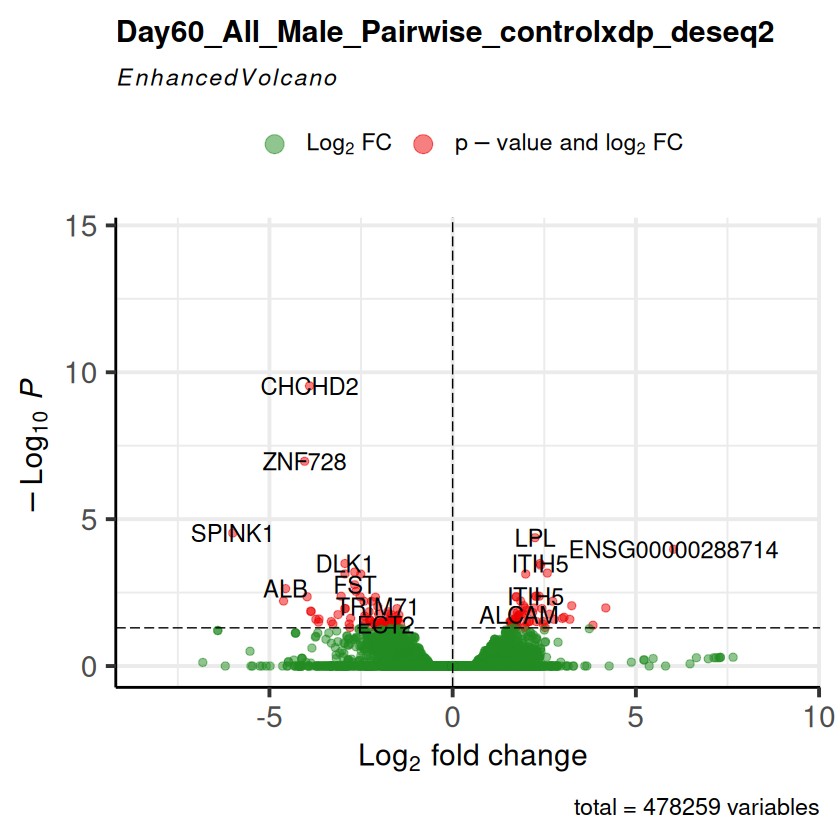

Saving 7 x 7 in image


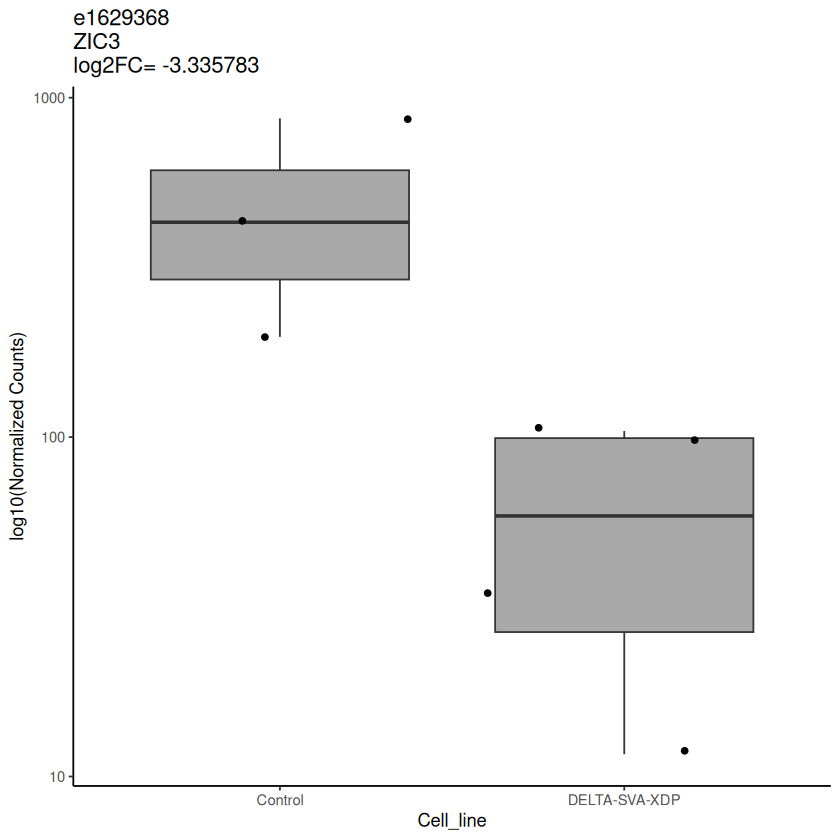

[1] "exon - Day60_All_Male_Pairwise_deltaxdp_deseq2"


factor levels were dropped which had no samples



  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



using pre-existing size factors



estimating dispersions



gene-wise dispersion estimates



mean-dispersion relationship



  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



final dispersion estimates



fitting model and testing




out of 487367 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 10, 0.0021%
LFC < 0 (down)     : 57, 0.012%
outliers [1]       : 0, 0%
low counts [2]     : 302366, 62%
(mean count < 16)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 487367 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 11, 0.0023%
LFC < 0 (down)     : 72, 0.015%
outliers [1]       : 0, 0%
low counts [2]     : 340162, 70%
(mean count < 28)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "raw pval"

out of 487367 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 2829, 0.58%
LFC < 0 (down)     : 1887, 0.39%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Saving 7 x 7 in image


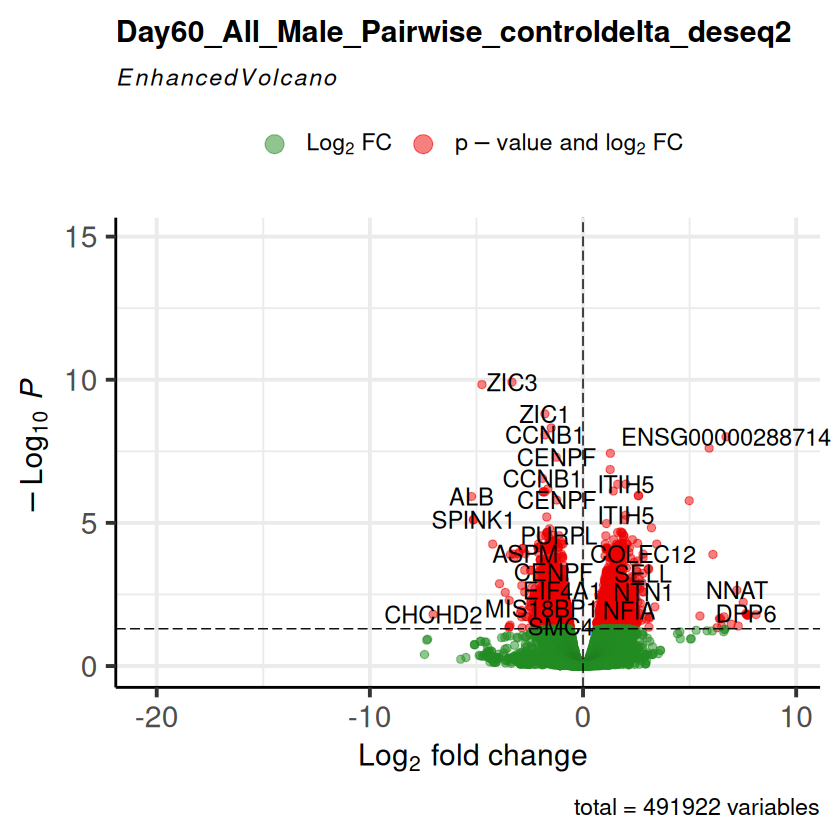

Saving 7 x 7 in image


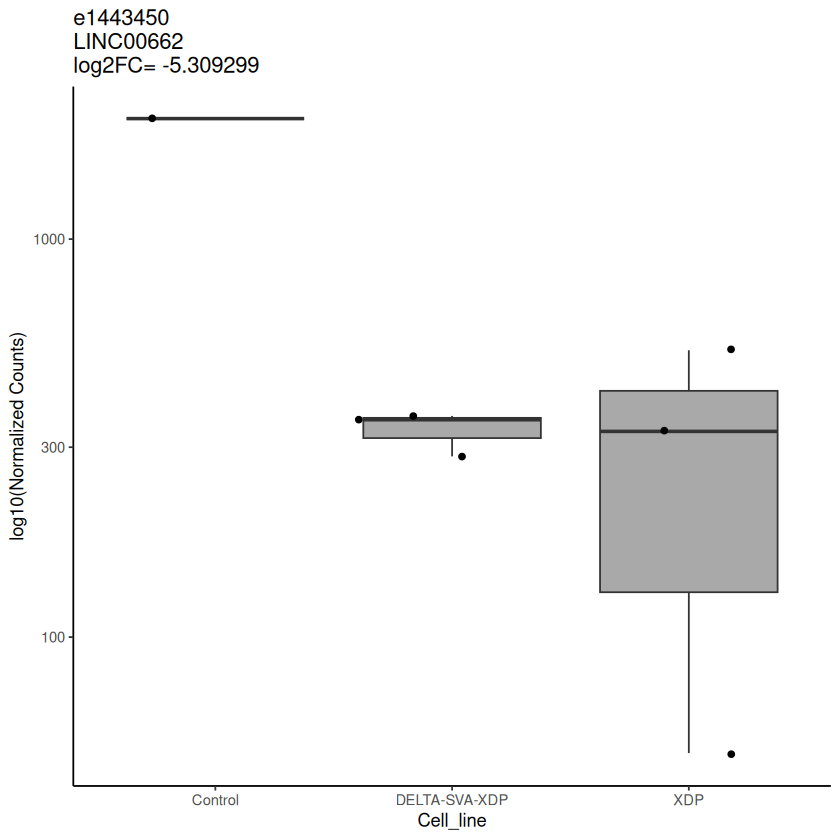

[1] "exon - Day90_All_Male_Pairwise_controlxdp_deseq2"


factor levels were dropped which had no samples



using pre-existing size factors



estimating dispersions



gene-wise dispersion estimates



mean-dispersion relationship



final dispersion estimates



fitting model and testing




out of 452205 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 1, 0.00022%
LFC < 0 (down)     : 1, 0.00022%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 452205 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 2, 0.00044%
LFC < 0 (down)     : 2, 0.00044%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "raw pval"

out of 452205 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 4087, 0.9%
LFC < 0 (down)     : 4728, 1%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Saving 7 x 7 in image


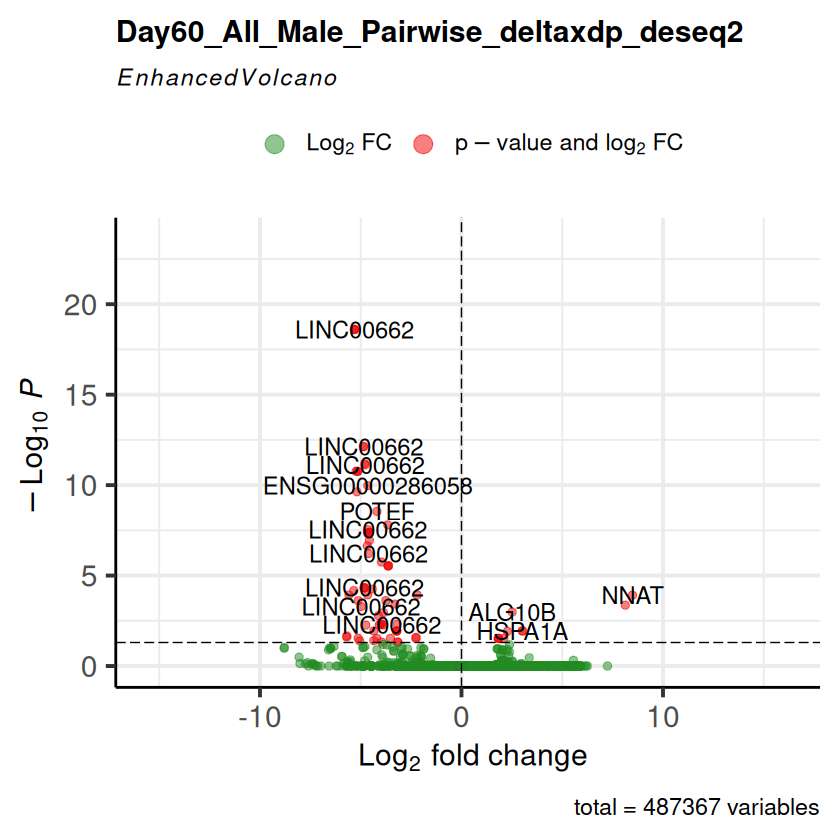

Saving 7 x 7 in image


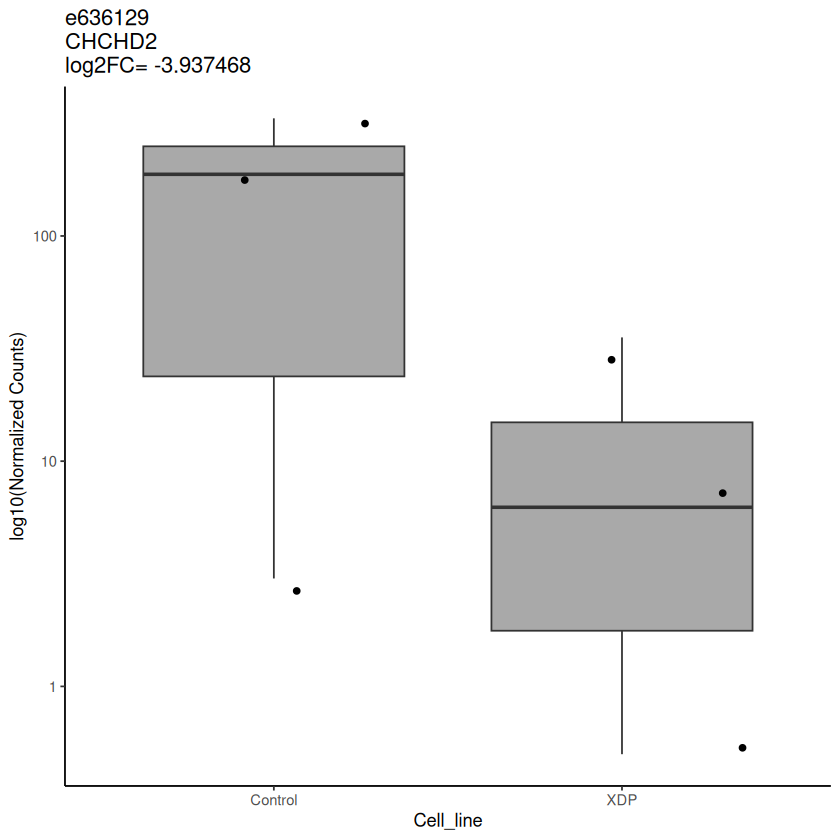

[1] "exon - Day90_All_Male_Pairwise_controldelta_deseq2"


factor levels were dropped which had no samples



  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



using pre-existing size factors



estimating dispersions



gene-wise dispersion estimates



mean-dispersion relationship



  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



final dispersion estimates



fitting model and testing




out of 451126 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 438, 0.097%
LFC < 0 (down)     : 2191, 0.49%
outliers [1]       : 0, 0%
low counts [2]     : 306121, 68%
(mean count < 21)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 451126 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 1642, 0.36%
LFC < 0 (down)     : 4133, 0.92%
outliers [1]       : 0, 0%
low counts [2]     : 297375, 66%
(mean count < 18)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "raw pval"

out of 451126 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 15423, 3.4%
LFC < 0 (down)     : 21671, 4.8%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Saving 7 x 7 in image


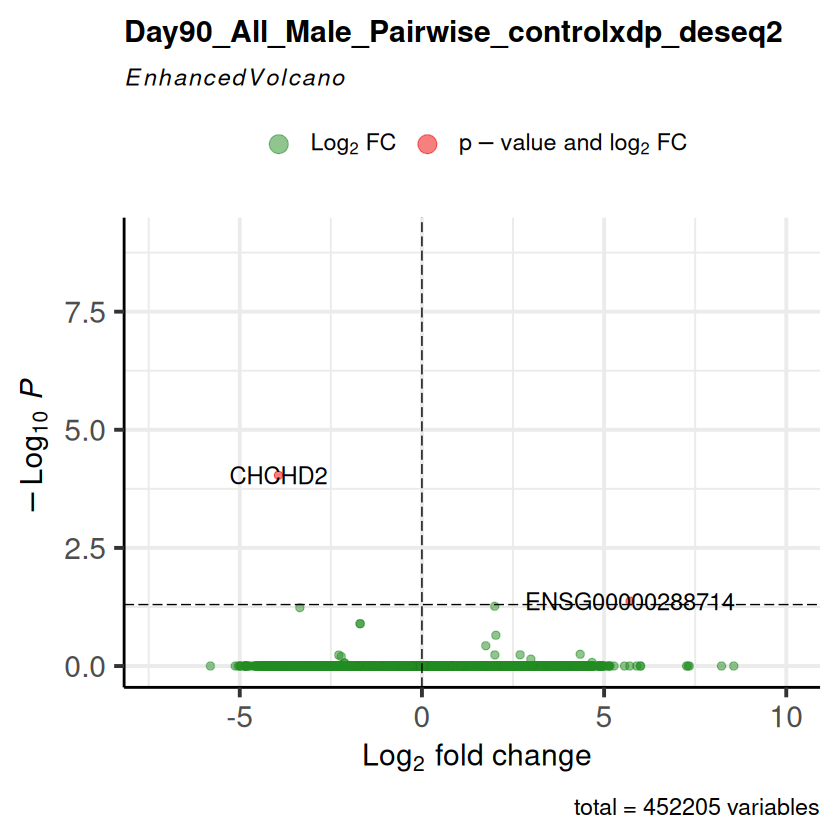

Saving 7 x 7 in image


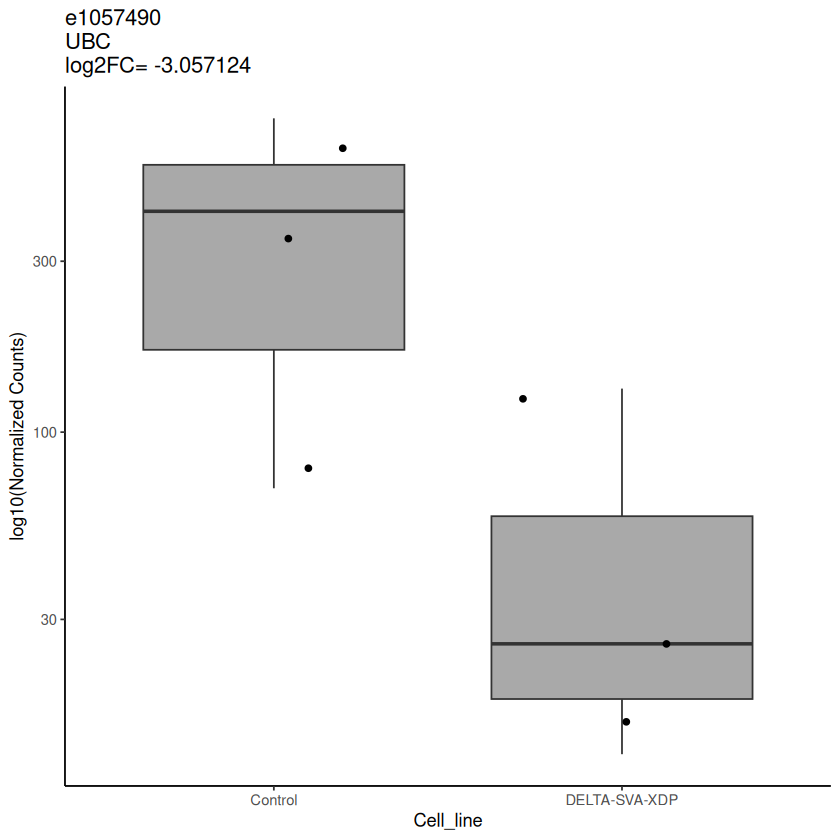

[1] "exon - Day90_All_Male_Pairwise_deltaxdp_deseq2"


factor levels were dropped which had no samples



  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



using pre-existing size factors



estimating dispersions



gene-wise dispersion estimates



mean-dispersion relationship



  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



final dispersion estimates



fitting model and testing




out of 418311 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 3, 0.00072%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 418311 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 3, 0.00072%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "raw pval"

out of 418311 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 442, 0.11%
LFC < 0 (down)     : 675, 0.16%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Saving 7 x 7 in image


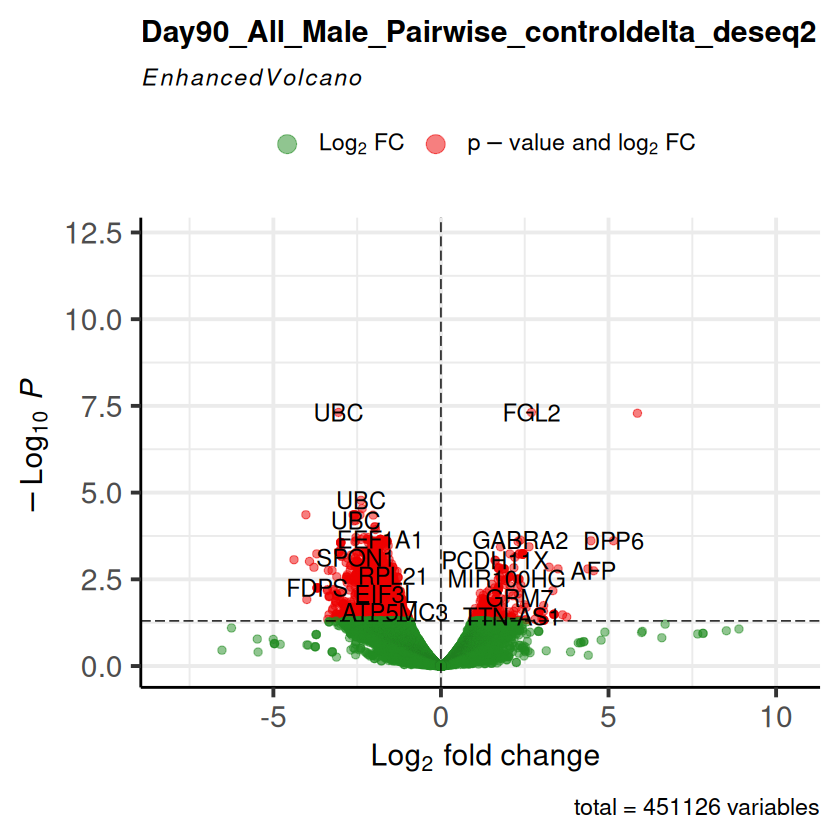

Saving 7 x 7 in image


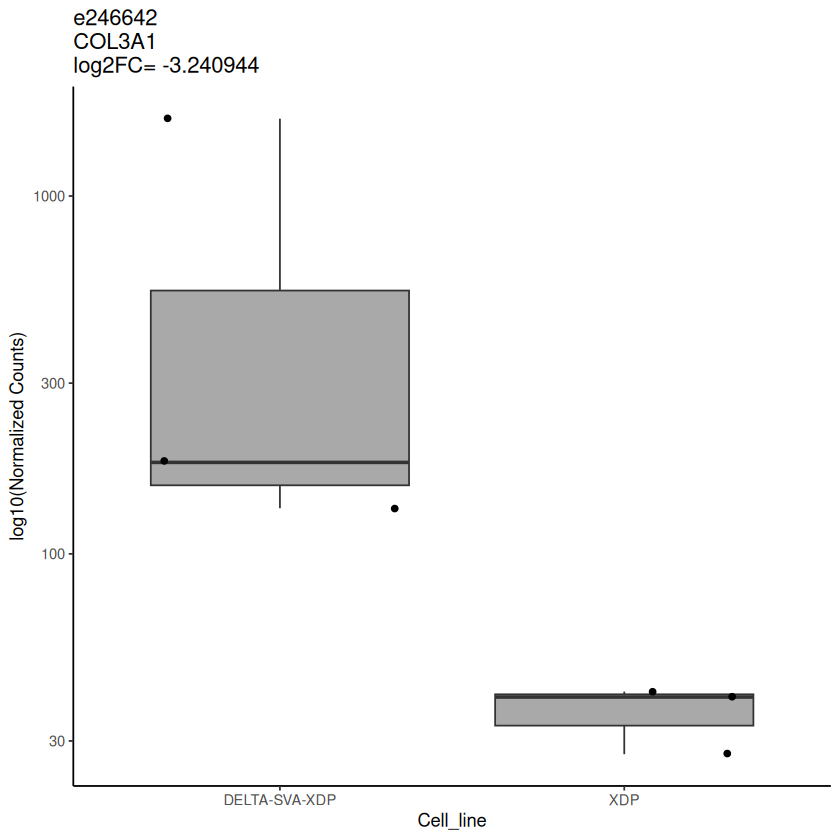

[1] "exon - Day120_All_Male_Pairwise_controlxdp_deseq2"


factor levels were dropped which had no samples



using pre-existing size factors



estimating dispersions



gene-wise dispersion estimates



mean-dispersion relationship



final dispersion estimates



fitting model and testing




out of 476937 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 407, 0.085%
LFC < 0 (down)     : 88, 0.018%
outliers [1]       : 0, 0%
low counts [2]     : 268155, 56%
(mean count < 12)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 476937 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 638, 0.13%
LFC < 0 (down)     : 163, 0.034%
outliers [1]       : 0, 0%
low counts [2]     : 258909, 54%
(mean count < 11)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "raw pval"

out of 476937 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 10146, 2.1%
LFC < 0 (down)     : 4898, 1%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Saving 7 x 7 in image


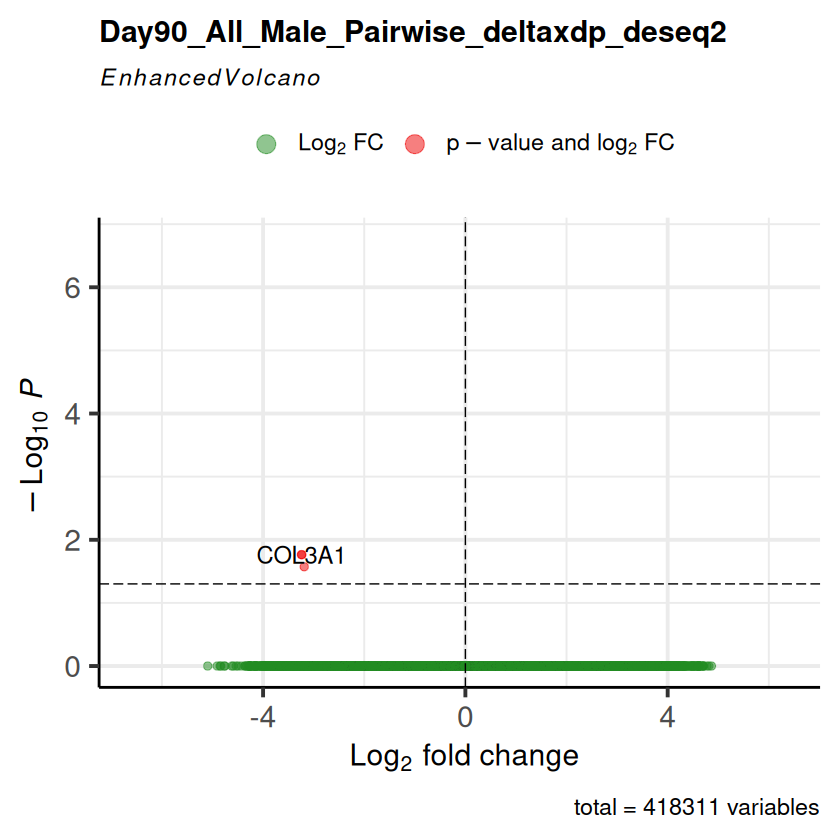

Saving 7 x 7 in image


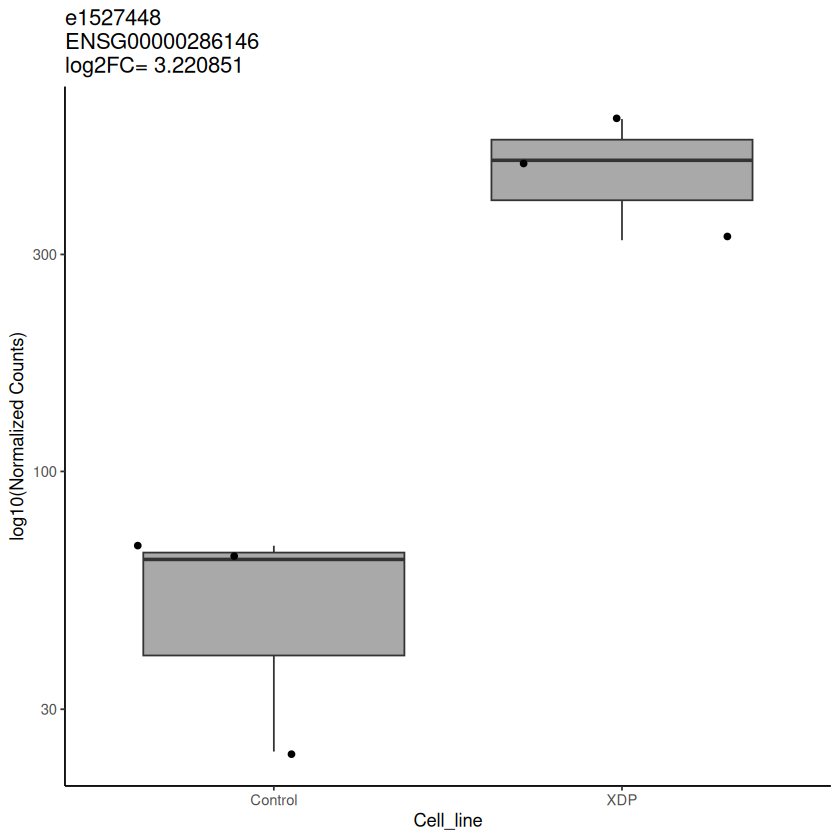

[1] "exon - Day120_All_Male_Pairwise_controldelta_deseq2"


factor levels were dropped which had no samples



  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



using pre-existing size factors



estimating dispersions



gene-wise dispersion estimates



mean-dispersion relationship



  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



final dispersion estimates



fitting model and testing




out of 488258 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 3877, 0.79%
LFC < 0 (down)     : 631, 0.13%
outliers [1]       : 0, 0%
low counts [2]     : 274521, 56%
(mean count < 16)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 488258 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 5603, 1.1%
LFC < 0 (down)     : 1147, 0.23%
outliers [1]       : 0, 0%
low counts [2]     : 283987, 58%
(mean count < 19)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "raw pval"

out of 488258 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 18428, 3.8%
LFC < 0 (down)     : 7338, 1.5%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Saving 7 x 7 in image


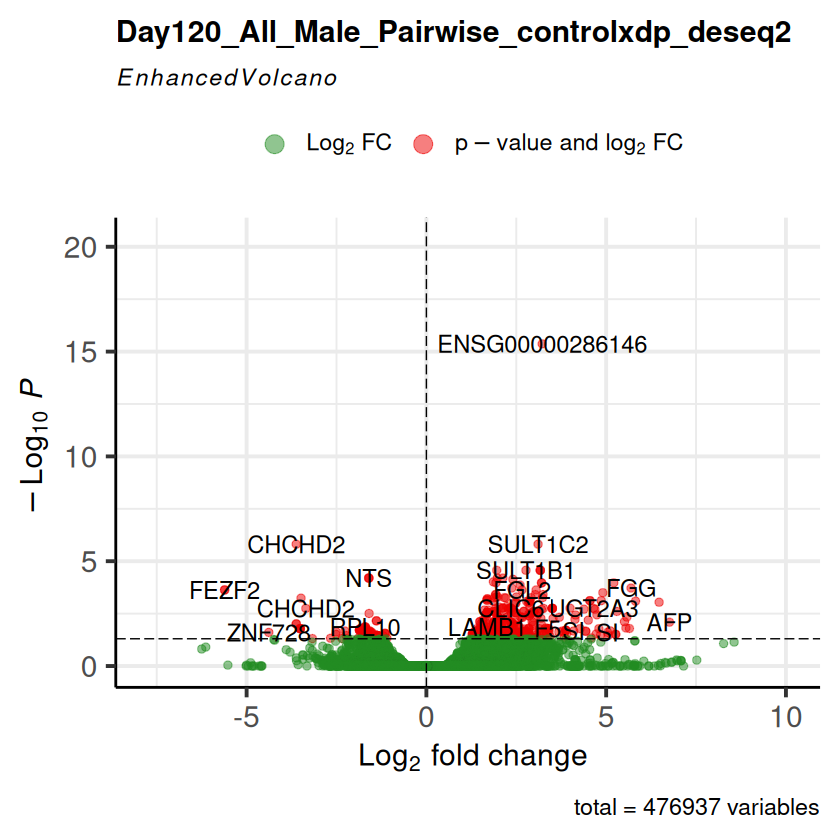

Saving 7 x 7 in image


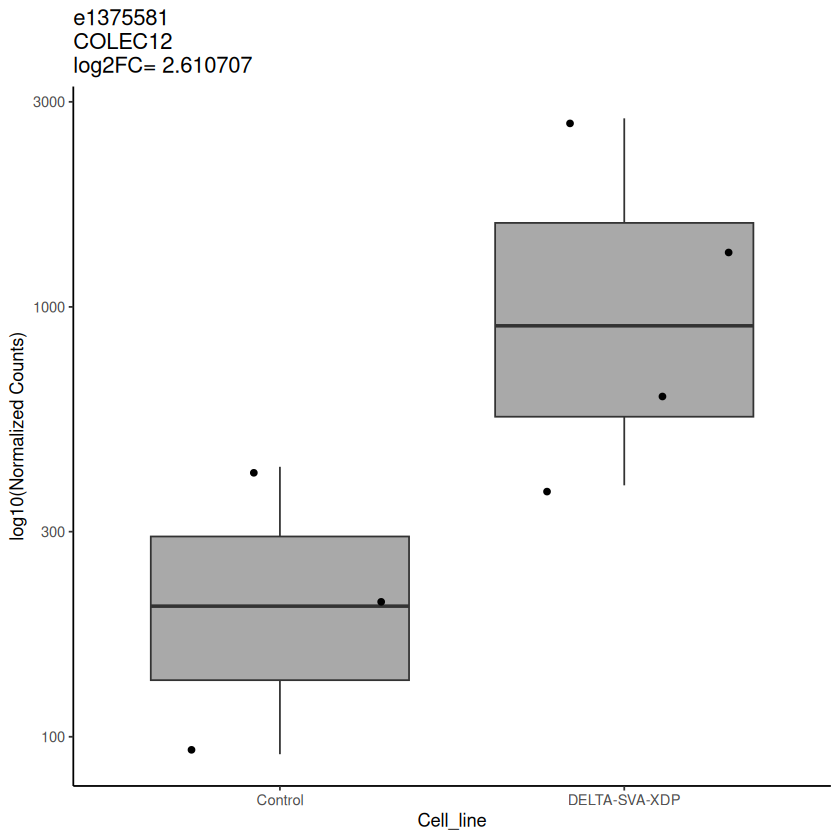

[1] "exon - Day120_All_Male_Pairwise_deltaxdp_deseq2"


factor levels were dropped which had no samples



  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



using pre-existing size factors



estimating dispersions



gene-wise dispersion estimates



mean-dispersion relationship



  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



final dispersion estimates



fitting model and testing




out of 482596 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 167, 0.035%
LFC < 0 (down)     : 89, 0.018%
outliers [1]       : 0, 0%
low counts [2]     : 261975, 54%
(mean count < 11)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 482596 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 258, 0.053%
LFC < 0 (down)     : 140, 0.029%
outliers [1]       : 0, 0%
low counts [2]     : 233911, 48%
(mean count < 8)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "raw pval"

out of 482596 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 9219, 1.9%
LFC < 0 (down)     : 7604, 1.6%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Saving 7 x 7 in image


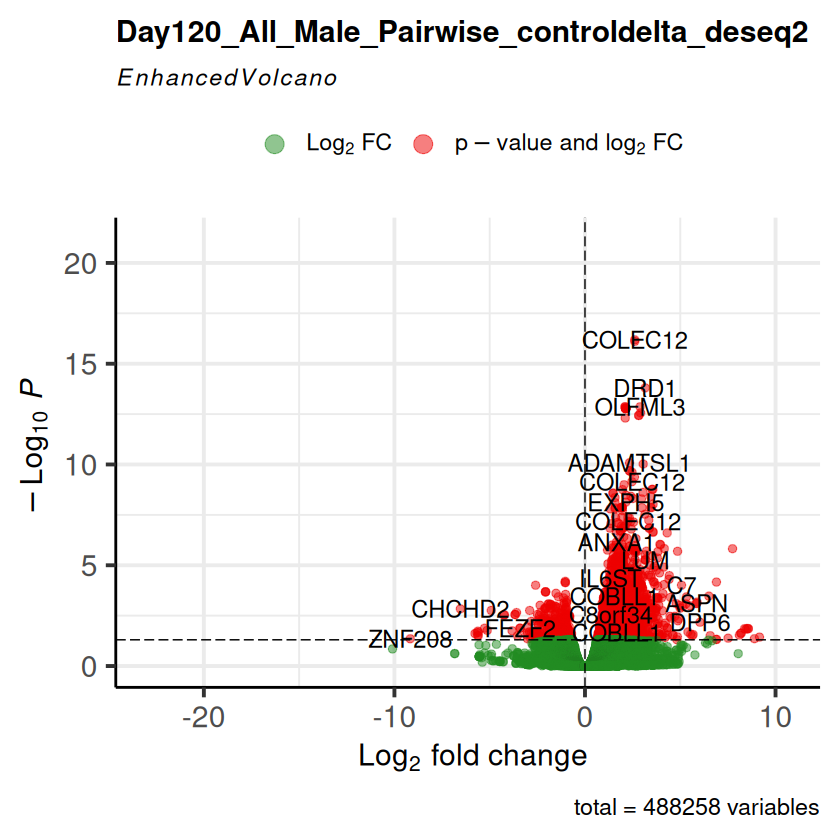

Saving 7 x 7 in image


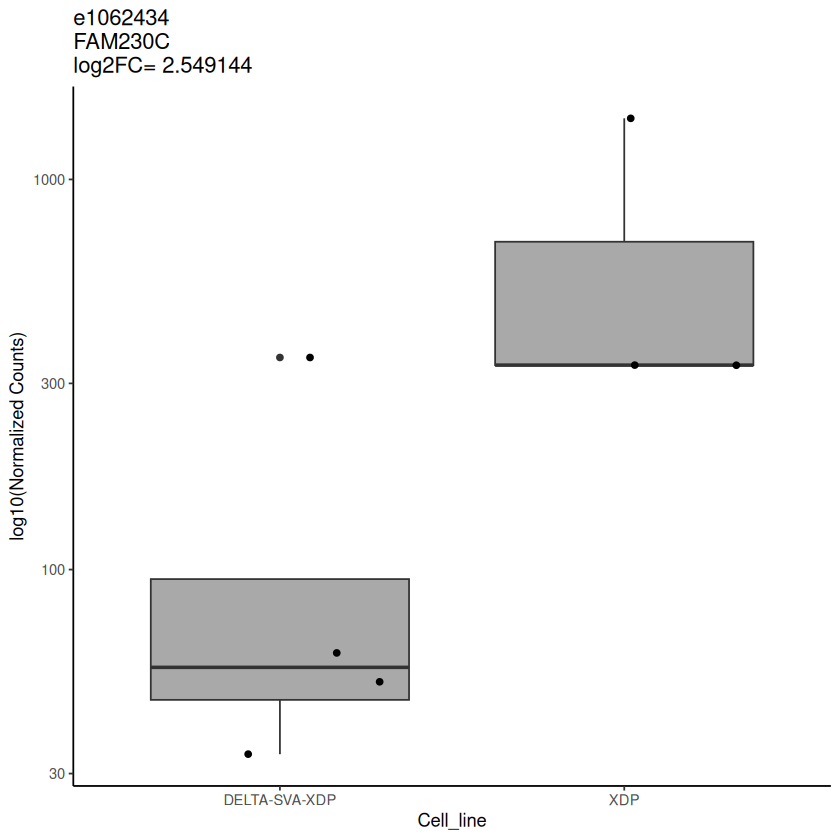

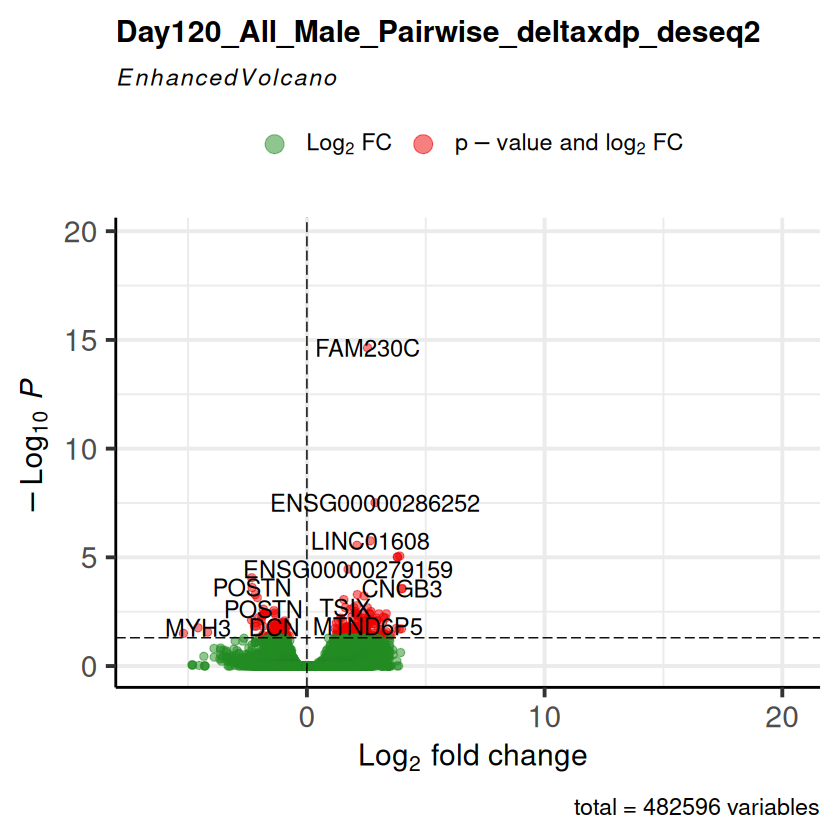

In [15]:
for (rse_var in rse_obj){

    rse_class <- ifelse(grepl('rse_gene',rse_var), 'gene',
                       ifelse(grepl('rse_exon',rse_var), 'exon', 
                            ifelse(grepl('rse_jx',rse_var), 'junction',
                                'transcript')
                              )
                        )


    annotated_rse_obj = merge_with_metadata(rse = get(rse_var), 
                                            metadata_df = metadata)


    for(model in analysis_version){

        sample_select <- deseq2_model %>%
                                        filter(deseq2 == model)

        sample_ids = colData(annotated_rse_obj) %>% 
                                                as_tibble() %>% 
                                                filter(SAMPLE_ID %in% sample_select$Sample) %>% 
                                                pluck('SAMPLE_ID')

        print(paste0(rse_class, ' - ', sample_select$deseq2[1]))


        a = deseq2_analysis(rse = annotated_rse_obj, 
                            rse_type = rse_class, #gene, kunction or exon rse_obj?
                            sample_ids = sample_ids,
                            #design = ~Cell_line, 
                            design = formula(paste0('~',sample_select$design[1])),
                            #design = ~RIN + Day_of_Maturation + Kit + new_Cell_line, 
                            analysis_name=sample_select$deseq2[1],
                            to_keep = genes_to_keep)

        }


}

In [16]:
sessionInfo()

R version 4.4.2 (2024-10-31)
Platform: x86_64-pc-linux-gnu
Running under: Arch Linux

Matrix products: default
BLAS:   /usr/lib/libblas.so.3.12.0 
LAPACK: /usr/lib/liblapack.so.3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: EST
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] EnhancedVolcano_1.24.0      ggrepel_0.9.6              
 [3] data.table_1.16.4           lubridate_1.9.4            
 [5] forcats_1.0.0               stringr_1.5.1              
 [7] dplyr_1.1.4                 purrr_1.0.2                
 [9] readr_2.1.5        